# Kezdeti érték problémák numerikus megoldása: járványmodellek

* A járványterjedés matematikai modellezésében és az előrejelzésben az ún. *kompartment modellek* jól alkalmazhatónak bizonyultak. 
* Ezen modellek közös jellemzője, hogy a járványnak kitett populációt csoportokra osztják és a csoportok létszámának alakulását valamilyen tömeghatáskinetikai elven felállított differenciálegyenlet rendszerrel írják le.
* A kompartment modellek a legtöbb esetben sztochasztikus járványterjedési modellek skálalimeszeiként állnak elő: a mikroszkópikus leírásban a populáció tökéletesen kevert, a kompartmentekben pedig egész számú ember található minden időpillanatban, az időfejlődést pedig folytonos idejű és diszkrét állapotterű Markov-folyamatok írják le.

A gyakorlat keretében néhány nevezetes kompartment modell példáján keresztül megismerkedünk a scipy alapvető differenciálegyenlet megoldó függvényeivel és interaktív alkalmazásokat készítünk.

## SIR járványterjedés (pl: kanyaró, mumpsz, rózsahimlő)

Az SIR járványmodell a populációt fogékonyakra (S), fertőzőkre (I) és fertőzésen átesettekre (R) osztja. Az, hogy a fertőzésen átesettek gyógyultak vagy halottak a modell szempotjából lényegtelen, kizárólag az számít, hogy az R kategóriába eső egyedek soha többé nem fertőznek. Az SIR modellben járványterjedést az alábbi diffenciálegyenlet írja le:

\begin{align}
\dot{S} &= -\frac{\beta}{N} I S \\
\dot{I} &= \frac{\beta}{N} I S-\gamma I \\
\dot{R} &= \gamma I
\end{align}

Az SIR modell jól alkalmazható a járvány lefutásának előrejelzésére abban az esetben, ha a betegség emberről emberre terjed és tartós immunitást alakít ki. Ilye betegség a kanyaró, mumpsz és a rózsahimlő.

A modellben a $\beta$ paraméter jellemzi a fertőzőképességet, $\gamma$ a felgyógyulás sebességét és $N$ a járványnak kitett populáció méretét. Az
$$
R_0 = \frac{\beta}{\gamma}
$$
reprodukciós szám az SIR modellnek megfelelő mikroszkópikus leírásban annak felel meg, hogy egy fertőzőképes egyed egy csupa fogékonyakból álló populációban egységnyi idő alatt várhatóan hány társát fertőzi meg.

**Az alábbiakban egy interaktív alkamazást készítünk, melynek segítségével a paraméterek változásának hatását nyomon követhetjük.**

<IPython.core.display.Javascript object>


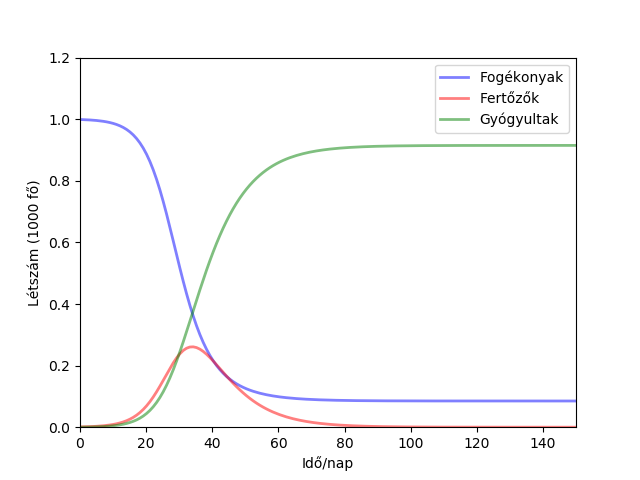

interactive(children=(FloatSlider(value=0.2, description='beta', max=0.4, min=0.1, step=0.05), FloatSlider(val…

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import autograd.numpy as np 
from scipy.integrate import odeint


# A differenciálegyenlet jobb oldala
def SIR_LHS(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


# Ábrázolás    
fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.set_xlabel('Idő/nap')
ax.set_ylabel('Létszám (1000 fő)')
ax.set_xlim(0,150)
ax.set_ylim(0,1.2)

lS, = ax.plot([], [], 'b', alpha=0.5, lw=2, label='Fogékonyak')
lI, = ax.plot([], [], 'r', alpha=0.5, lw=2, label='Fertőzők')
lR, = ax.plot([], [], 'g', alpha=0.5, lw=2, label='Gyógyultak')

ax.legend()

# Kezdeti értékek
N = 1000  # S+I+R=N a populáció mérete a szimuláció során állandó (kb. egy kis zárt falu)

# 1 fertőzött érkezik a faluba
I0, R0 = 1.0, 0.0

# Tehát mindenki más még fogékony
S0 = N - I0 - R0

# A következő kb. 5 hónap fejleményeire leszünk kiváncsiak, ezért 150 napot veszünk
t = np.linspace(0, 150, 150)

# kezdeti érték vektor
y0 = S0, I0, R0

@interact(beta=(0.1,0.4,0.05),gamma=(0.05,0.5,0.01))
def simulation(beta=0.2,gamma=0.1):
    """
    SIR modell interaktív szimulációja
    """
    
    # Numerikus megoldás
    ret = odeint(SIR_LHS, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    # ax.clear()
    lS.set_data(t,S/1000)
    lI.set_data(t,I/1000)
    lR.set_data(t,R/1000)


## Feladat: SIS járványterjedés (pl: megfázás, influenza)

Vannak olyan fertőző betegségek (pl: megfázás, influenza), amelyek nem alakítanak ki tartós védettséget, azaz "akárhányszor el lehet kapni őket". Ilyen típusú járványterjedést ír le az SIS modell:
\begin{align}
\dot{S} &= -\frac{\beta}{N}IS+\gamma I \\
\dot{I} &= \frac{\beta}{N}IS-\gamma I 
\end{align}

**Az SIR modell mintájára írjunk Python programot, melyben a $\beta$ és $\gamma$ paramétereket változtatni tudjuk (a határokat az SIR szimulációból vegyük).** 

## Feladat: SEIRS járványterjedés (egy szofisztikáltabb modell)

Az SEIRS modell olyan járványterjedési karakterisztikát ír le, ahol megfertőződés és a fertőzőképessé válás közé egy lappangó (E) periódus ékelődik be. Az SIR modellhez képest pluszként jelenik meg, hogy van halálozás és a gyógyultak egy idő után újra fogékonnyá válnak a fertőzésre.

Az SEIRS modell differenciálegyenlet rendszere:
\begin{align}
\dot{S} &= \underbrace{\mu N}_{születés}-\underbrace{\frac{\beta}{N}IS}_{fertőződés} + \underbrace{\omega R}_{védettség\, elvesztése}
-\underbrace{\mu S}_{természetes\, halálozás} \\
\dot{E} &= \underbrace{\frac{\beta}{N}IS}_{fertőződés}-\underbrace{\sigma E}_{lappangás}-\underbrace{\mu E}_{természetes\, halálozás} \\
\dot{I} &= \underbrace{\sigma E}_{lappangás} - \underbrace{\gamma I}_{gyógyulás}-\underbrace{(\mu + \alpha) I}_{halálozás} \\
\dot{R} &= \underbrace{\gamma I}_{gyógyulás} - \underbrace{\omega R}_{védettség\, elvesztése} - \underbrace{\mu R}_{természetes\, halálozás} \\
N &= S+E+I+R
\end{align}

A modell egy egyensúlyban lévő populációra van felírva, ahol ugyanolyan $\mu>0$ rátával születnek és halnak meg az egyedek. A járvány hatására a fertőzötteket egy extra $\alpha>0$ halálozási ráta terheli.

**Készítsünk SEIR modell szimulációt (nem kell, hogy interaktív legyen).**

Javasolt paraméter értékek: $1/\gamma = 14\,nap$, $1/\sigma = 7\,nap$, $1/\omega = 1\,év$, $1/\mu = 76\,év$, $\beta = 0.21\,nap^{-1}$, $1/\alpha= 7\,nap$.

A kezdeti értékek pedig legyenek: $S(0)=10^6$, $E(0)=10.0$, $I(0)=R(0)=0.0$.

## Szorgalmi feladat: $\delta$ és $\omega$ COVID19 vírustörzsek versengése

Állítsunk fel egy olyan járványtejedési modellt (írjuk fel a differenciálegyenlet rendszert), ami két vírustörzs versengését írja le ($I_1$ és $I_2$ kompartmentek). 
* Az egyszerűség kedvéért tételezzük fel, hogy csak a fertőzési ráták különböznek: $\beta_1\gg\beta_2$. 

* Tehát minden más azonos és egyszerre csak az egyik változattal lehet megfertőződni, továbbá aki immunis, az mindkét variánssal szemben legyen immunis. 

* Akármelyik bemutatott járványterjedési modellt alapul vehetjük, itt most nem a szofisztikáltság a lényeg, hanem, hogy bemutassuk azt, hogy hosszú távon az $1$-es variáns lesz a domináns. 

* Készítsünk szimulációt.

# További olvasnivalók

1. https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology (Bevezető Wikipédia cikk a kompartment modellekről)

2. https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/ (egy SIR modell implementáció)

3. https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html (Scipy odeint dokumentáció)

4. https://www.nature.com/articles/s41592-020-0856-2 (Nature cikk az SEIRS modellről)

5. https://www.sciencedirect.com/science/article/pii/S221137972100749X (Friss cikk a modell paraméterek becsléséről a sztochasztikus SEIRS modellben: COVID19)

**Ajánlott feladat:** próbáljuk meg számba venni a kompartment modellek korlátait (pl: inhomogén, nem tökéletesen keveredő populáció, több vírustörzs egyidejű jelenléte)